List of Hands on Experiments:


1. Hands-on: Fine-tuning ResNet and MobileNet on industrial dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

# Convert grayscale (28x28) to RGB (28x28x3) for pretrained models
x_train = np.stack((x_train,)*3, axis=-1)
x_val = np.stack((x_val,)*3, axis=-1)

# Normalize images
x_train = x_train.astype("float32") / 255.0
x_val = x_val.astype("float32") / 255.0

# Resize images to 224x224 
resize_layer = tf.keras.Sequential([
    layers.Resizing(224, 224)
])

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).map(lambda x, y: (resize_layer(x), y))
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32).map(lambda x, y: (resize_layer(x), y))

In [ ]:
base_resnet = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_resnet.trainable = False  

resnet_model = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")  # MNIST has 10 classes (digits 0–9)
])

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nTraining ResNet50...")
resnet_model.fit(train_ds, validation_data=val_ds, epochs=5)


Training ResNet50...
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 193s 97ms/step - accuracy: 0.2675 - loss: 2.1727 - val_accuracy: 0.6702 - val_loss: 1.5183
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 176s 94ms/step - accuracy: 0.5776 - loss: 1.4513 - val_accuracy: 0.7744 - val_loss: 1.0272
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 176s 94ms/step - accuracy: 0.6947 - loss: 1.0679 - val_accuracy: 0.8207 - val_loss: 0.7748
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 202s 94ms/step - accuracy: 0.7537 - loss: 0.8575 - val_accuracy: 0.8391 - val_loss: 0.6401
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 202s 94ms/step - accuracy: 0.7897 - loss: 0.7280 - val_accuracy: 0.8677 - val_loss: 0.5339


In [ ]:
base_resnet.trainable = True
for layer in base_resnet.layers[:-30]:
    layer.trainable = False

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nFine-tuning ResNet50 (last 30 layers)...")
resnet_model.fit(train_ds, validation_data=val_ds, epochs=2)


Fine-tuning ResNet50 (last 30 layers)...
Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 264s 132ms/step - accuracy: 0.8634 - loss: 1.1382 - val_accuracy: 0.9753 - val_loss: 0.0830
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 240s 128ms/step - accuracy: 0.9658 - loss: 0.1156 - val_accuracy: 0.9813 - val_loss: 0.0575


In [ ]:
# Evaluate model on validation/test data
test_loss, test_acc = resnet_model.evaluate(val_ds)
print("\nResNet50 Model Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.9771 - loss: 0.0710

ResNet50 Model Evaluation:
Test Loss: 0.0575
Test Accuracy: 0.9813



Evaluating model on validation dataset...
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.9771 - loss: 0.0710

Validation Accuracy: 0.9813
Validation Loss: 0.0575
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step


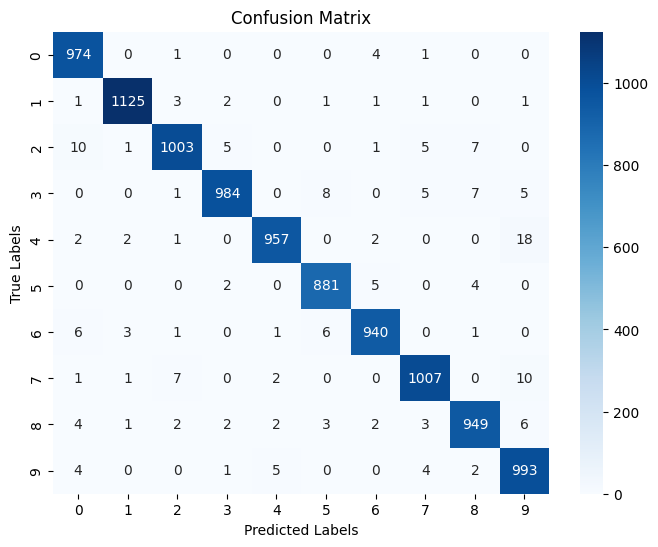


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.99      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model performance on the validation dataset
print("\nEvaluating model on validation dataset...")
test_loss, test_acc = resnet_model.evaluate(val_ds)
print(f"\nValidation Accuracy: {test_acc:.4f}")
print(f"Validation Loss: {test_loss:.4f}")

# Get predictions and true labels
y_pred = np.argmax(resnet_model.predict(val_ds), axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

2. Hands-on: Object detection using YOLOv5/ v8 training

In [ ]:
pip install ultralytics tensorflow keras opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.2 MB/s eta 0:00:00


In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Load a pre-trained YOLOv8 model
model = YOLO("yolov8n.pt")  

In [ ]:
# Load an image
img_path = "football1.webp"
img = cv2.imread(img_path)

results = model(img)



0: 384x640 5 persons, 18.3ms
Speed: 7.0ms preprocess, 18.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


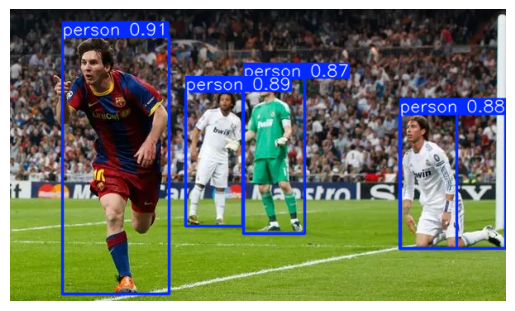

Detected: person (Confidence: 0.91)
Detected: person (Confidence: 0.89)
Detected: person (Confidence: 0.88)
Detected: person (Confidence: 0.87)
Detected: person (Confidence: 0.41)


In [39]:
# Visualize
for r in results:
    annotated = r.plot()  # Draw bounding boxes
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Print detected classes and confidences
for box in results[0].boxes:
    cls = int(box.cls[0])
    conf = float(box.conf[0])
    print(f"Detected: {model.names[cls]} (Confidence: {conf:.2f})")
